In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pickle
import matplotlib.pyplot as plt
import spacy
import re
from tqdm import tqdm
CURRENT_DIR = os.getcwd()
import time
nlp = spacy.load('en')
import string
punc = set(string.punctuation)
import pylab as pl
from stemming.porter2 import stem
from gensim import utils
lem_dict = {} #for memoization
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [4]:
##Separate stem function that makes use of memoization to decrease time taken for stemming over 400000 words

def load_stem_dict(force = False):
    if not os.path.exists('global_stem_dict.pkl') or force ==True:
        global_stem_dict = {}
        global_stem_flag = False
    else:
        print("Loading global stemming dictionary")
        global_stem_dict = pickle.load(open('global_stem_dict.pkl',"rb"))
        global_stem_flag = True
    return global_stem_dict, global_stem_flag
#global_stem_dict will hold words as keys and stemmed words as values
#global_stem_flag is True if global_stem_dict was loaded from pickle file, False otherwise
#this flag is so that we unnecessarily don't write into the pickle file again in the process_data function
global_stem_dict,global_stem_flag = load_stem_dict(force = False)



def stem2(sentence):
    words = sentence.split()
    for i in range(0,len(words)):
        try:
            words[i] = global_stem_dict[words[i]]
        except KeyError:
            s =  stem(words[i])
            global_stem_dict[words[i]] = s
            words[i] = s
    return ' '.join(words)

   


def process_data(stemmed = False, tokenized = False, force = False):
    #Load the global stemming dictionary
    global global_stem_dict
    global global_stem_flag
    if not os.path.exists("processed_data.pkl") or force == True:
        ##Input the data
        print("Processing and saving data...")
        train_variants = pd.read_csv("./training_variants")
        test_variants = pd.read_csv("./test_variants")
        train_temp_df = pd.read_csv("./training_text",sep = "\|\|", engine = "python", 
                                 header = None, skiprows = 1,names = ["ID","Text"] )
        test_df = pd.read_csv("./test_text",sep = "\|\|", engine = "python", 
                                 header = None, skiprows = 1,names = ["ID","Text"] )


        #Join the text and variants columns
        train_temp_df = train_temp_df.join(train_variants.set_index("ID"), on = "ID")
        test_df = test_df.join(test_variants.set_index("ID"), on = "ID")
        
        
        train_temp_df["Text"].astype(str)
        test_df["Text"].astype(str)
        
        if tokenized == True:
            start = time.time()
            print("Lowercasing and tokenizing now")
            train_temp_df["Text"] = train_temp_df["Text"].apply(lambda sen: ' '.join(list(utils.tokenize(sen.lower()))))
            test_df["Text"] = test_df["Text"].apply(lambda sen: ' '.join(list(utils.tokenize(sen.lower()))))
            print("Time taken for tokenization: " + str(time.time() - start))
        else:
            print("Skipping tokenizing, lowercasing and punc removal.")
        
        if stemmed == True:
            print("Stemming now")
            start = time.time()
            ##Stemming starts here
            train_temp_df["Text"] = train_temp_df["Text"].apply(stem2)
            test_df["Text"] = test_df["Text"].apply(stem2)
            #Save into 'global_stem_dict.pkl' so that it can be loaded later by load_stem_dict() function
            if global_stem_flag == True:
                print("Stemmed words were loaded from existing pickle file. Skipping pickling.")
            else:
                print("Global stem dictionary was reinitialized. Pickling...")
                pickle.dump(global_stem_dict,open("global_stem_dict.pkl","wb"), protocol=2)
            print("Time taken for stemming operation: " + str(time.time() - start))
        else:
            print("Skipping stemming.")
        
        ## Concatenate the Gene and Variation data along with the Text field
        train_temp_df['Text'] = train_temp_df.Text.str.cat(train_temp_df.Gene, sep=' ').str.cat(train_temp_df.Variation, sep=' ')
        test_df['Text'] = test_df.Text.str.cat(test_df.Gene, sep=' ').str.cat(test_df.Variation, sep=' ')
        #Add text counts as a feature
        train_temp_df.loc[:,"Text_Word_Count"] = train_temp_df["Text"].apply(lambda x: len(x.split()))
        test_df.loc[:,"Text_Word_Count"] = test_df["Text"].apply(lambda x: len(x.split()))
        train_temp_df.loc[:,"Text_Char_Count"] = train_temp_df["Text"].apply(lambda x: len(x))
        test_df.loc[:,"Text_Char_Count"] = test_df["Text"].apply(lambda x: len(x))
        processed_data = {"train_temp_df": train_temp_df,
                          "test_df": test_df
                         }
        pickle.dump(processed_data,open("processed_data.pkl",'wb'), protocol = 2)
        print("Data saved.")

    else:
        print("Loading existing data")
        processed_data = pickle.load(open("processed_data.pkl","rb"))
        train_temp_df = processed_data["train_temp_df"]
        test_df = processed_data["test_df"]
        print("Existing data loaded.")
    return train_temp_df, test_df

train_temp_df, test_df = process_data(stemmed = False, tokenized = False, force = True)



print("Training Dataframe shape: " + str(train_temp_df.shape))
print("Testing Dataframe shape: " + str(test_df.shape))


Loading global stemming dictionary
Processing and saving data...
Skipping tokenizing, lowercasing and punc removal.
Skipping stemming.
Data saved.
Training Dataframe shape: (3321, 7)
Testing Dataframe shape: (5668, 6)


In [8]:
import spacy
nlp = spacy.load('en')
doc = nlp(unicode(train_temp_df["Text"][0],errors = "ignore"))

In [32]:
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
sentences = list(doc.sents)
print([word for word in sentences[0] if not word in stops])
#print(list((sen. for sen in sentences[0:10])))

LookupError: 
**********************************************************************
  Resource u'corpora/stopwords' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/home/nitin/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

In [3]:

"""
#Tried this splitting method and found that classes 8 and 9 were not represented
#in the validation set.
from sklearn.model_selection import train_test_split
#Split the training data into train and validation sets
train_df, valid_df = train_test_split(train_temp_df, test_size = 0.2)
"""
#Lets use StratifiedShuffleSplit to represent each class equally in both train and validation sets
from sklearn.model_selection import StratifiedShuffleSplit
stratSplit = StratifiedShuffleSplit( n_splits = 3, test_size=0.2,
                                    random_state=42).split(train_temp_df, train_temp_df["Class"].tolist())

ss = list(stratSplit)[0]


train_df = train_temp_df.iloc[ss[0]].reset_index()
valid_df = train_temp_df.iloc[ss[1]].reset_index()

##Lets make sure that the classes are represented equalling 
tc = train_df.groupby("Class")["Class"].count()
vc = valid_df.groupby("Class")["Class"].count()
print(tc,vc)
print(train_df["Text"].keys())

(Class
1    454
2    361
3     71
4    549
5    194
6    220
7    762
8     15
9     30
Name: Class, dtype: int64, Class
1    114
2     91
3     18
4    137
5     48
6     55
7    191
8      4
9      7
Name: Class, dtype: int64)
RangeIndex(start=0, stop=2656, step=1)


In [25]:
from imblearn.under_sampling import NearMiss
nm = NearMiss(random_state=42, version = 2)
X_res, y_res = nm.fit_sample(train_feats, train_labels)
print(len(X_res), len(y_res))

(135, 135)


In [4]:
from stemming.porter2 import stem

def ngram_hash(sentence,n=3):
    sentence = sentence.replace(' ','#')
    return ' '.join(sentence[i:i+n] for i in range(0,len(sentence)-n))


def find_word_stats(df,fname,force = False):
    if not os.path.exists(fname + ".pkl") or  force == True:
        print("Calculating word stats.")
        #Let's see how many words are there
        all_words = ' '.join(df["Text"]).split()
        unique_words = set(all_words)
        lower_unique = set(' '.join(df["Text"]).lower().split())
        stemmed_lower_unique = set([stem(w) for w in lower_unique])
        print("Total number of words: " + str(len(all_words)))
        print("Total number of unique words: " + str(len(unique_words)))
        print("Total number of unique words after lower case: " + str(len(lower_unique)))
        print("Total number of unique words after lower case and stemming: " + str(len(stemmed_lower_unique)))
        word_stats = {
            "len_all_words": str(len(all_words)),
            "len_unique_words": str(len(unique_words)),
            "len_lower_unique": str(len(lower_unique)),
            "len_stemmed_lower_unique": str(len(stemmed_lower_unique))
        }
        pickle.dump(word_stats,open(fname + ".pkl","wb"),protocol=2)
        print("Stats stored in word_stats.pkl")
    else:
        print("Loading word stats.")
        word_stats = pickle.load(open(fname + ".pkl","rb"))
        len_all_words = word_stats["len_all_words"]
        len_unique_words = word_stats["len_unique_words"]
        len_lower_unique = word_stats["len_lower_unique"]
        len_stemmed_lower_unique = word_stats["len_stemmed_lower_unique"]
        print("Total number of words: " + len_all_words)
        print("Total number of unique words: " + len_unique_words)
        print("Total number of unique words after lower case: " + len_lower_unique)
        print("Total number of unique words after lower case and stemming: " + len_stemmed_lower_unique)
        print("Stats loaded from word_stats.pkl")
    return word_stats

train_word_stats = find_word_stats(train_temp_df,"train_temp_df_stats")



Loading word stats.
Total number of words: 31697301
Total number of unique words: 488591
Total number of unique words after lower case: 457437
Total number of unique words after lower case and stemming: 439816
Stats loaded from word_stats.pkl


In [5]:
##Let's add word2vec features with gensim
## We will train it with the only processing used being the lowercase filter.
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

def build_w2v(text_array, force = False):
    if not os.path.exists("./w2v_model") or force == True:
        print("Model does not exist. Training model...")
        w2v_model = Word2Vec(train_temp_df["Text"].apply(lambda x: x.lower().split()), 
                             size=100, window=5, min_count=5, workers=4)
        w2v_model.save("w2v_model")
        word_vectors = w2v_model.wv
        word_vectors.save("word_vectors")
        print("Model and Word Vectors trained and saved...")
        print("The most similar words to 'clinical' are: " + str(word_vectors.most_similar('clinical')))
    else:
        print("Loading existing model")
        w2v_model = Word2Vec.load("w2v_model")
        word_vectors = KeyedVectors.load("word_vectors")
        print("Word2Vec model and word vectors loaded...")
        print("The most similar words to 'clinical' are: " + str(word_vectors.most_similar('clinical')))
    return w2v_model, word_vectors

w2v_model, word_vectors = build_w2v(train_temp_df["Text"])
    

Using TensorFlow backend.


Loading existing model
Word2Vec model and word vectors loaded...
The most similar words to 'clinical' are: [('therapeutic', 0.608913779258728), ('diagnostic', 0.5986784100532532), ('clinicopathological', 0.593536913394928), ('clinicopathologic', 0.5916438102722168), ('randomised', 0.5887097120285034), ('pathologic', 0.5514856576919556), ('prospective', 0.5512081384658813), ('prognostic', 0.5504527688026428), ('safety', 0.5188233256340027), ('ongoing', 0.5186888575553894)]


In [6]:
##Let's perform doc2vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
from gensim import utils

class LabeledLineSentence(object):
    def __init__(self, df):
        self.text_array = df["Text"].tolist()
        self.labels = df["Class"].tolist()
    def __iter__(self):
        for i,line in tqdm(enumerate(self.text_array)):
            yield LabeledSentence(words=utils.to_unicode(line.lower()).split(), tags=["Class" + str(self.labels[i])])

def build_d2v(text_array, fname, force = False):
    start = time.time()
    if not os.path.exists(fname) or force == True:
        print("Training Doc2Vec model...")
        lb = LabeledLineSentence(text_array)
        d2v_model = Doc2Vec(lb, size=100, window=8, min_count=1, workers=4)
        d2v_model.save(fname)
        print("Model saved.")
    else:
        print("Loading existing model...")
        d2v_model = Doc2Vec.load(fname)  # you can continue training with the loaded model!
        print("Doc2Vec model loaded...")
    print("Time taken: " + str(time.time() - start))
    return d2v_model

d2v_model_train = build_d2v(train_df,"d2v_model_train", force = False)
d2v_model_valid = build_d2v(valid_df["Text"].tolist(),"d2v_model_valid", force = False)
d2v_model_test = build_d2v(test_df["Text"].tolist(),"d2v_model_test", force = False)

Loading existing model...
Doc2Vec model loaded...
Time taken: 6.62736701965
Loading existing model...
Doc2Vec model loaded...
Time taken: 3.23418712616
Loading existing model...
Doc2Vec model loaded...
Time taken: 8.49217796326


In [4]:

##Create training and validation labels
train_labels = train_df["Class"].tolist()
valid_labels = valid_df["Class"].tolist()

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


if os.path.exists(os.path.join(CURRENT_DIR, 'PM_data.pkl')):
    data_to_store = pickle.load(open('PM_data.pkl','rb'))
    train_tfidf_feats = data_to_store["train_tfidf_feats"]
    valid_tfidf_feats = data_to_store["valid_tfidf_feats"]
    test_tfidf_feats = data_to_store["test_tfidf_feats"]
    tfidf = pickle.load(open("TFIDF_Vectorizer.pkl","rb"))
    print("Loaded existing TFIDF data")
else:
    tfidf = TfidfVectorizer(lowercase = True, use_idf = True, strip_accents = "unicode",
                            min_df = 5, max_features = 16000, token_pattern = r"\w+",
                            smooth_idf=True, sublinear_tf=True,ngram_range=(1,3),
                            stop_words = 'english').fit(train_temp_df["Text"])
    
    print("Created and fit the TFIDFvectorizer with text data.")
    
    pickle.dump(tfidf,open("TFIDF_Vectorizer.pkl","wb"),protocol=2)
    print("Saved TFIDF Vectorizer in a pickle file.")
    train_tfidf_feats = tfidf.transform(train_df["Text"])
    valid_tfidf_feats = tfidf.transform(valid_df["Text"])
    test_tfidf_feats = tfidf.transform(test_df["Text"])
    print("Transformed train, valid and test text arrays.")

    #Convert each tfidf array into a numpy array so that we can append additional features to it later.
    train_tfidf_feats = train_tfidf_feats.toarray()
    valid_tfidf_feats = valid_tfidf_feats.toarray()
    test_tfidf_feats = test_tfidf_feats.toarray()
    print("Storing TFIDF features into a pickle file.")
    data_to_store = {
            "train_tfidf_feats": train_tfidf_feats,
            "valid_tfidf_feats": valid_tfidf_feats,
            "test_tfidf_feats": test_tfidf_feats}
    pickle.dump(data_to_store, open("PM_data.pkl","wb"), protocol = 2)
    
    print("Finished vectorizing the data")
print("Train Tfidf features shape: " + str(train_tfidf_feats.shape))
print("Validation Tfidf features shape: " + str(valid_tfidf_feats.shape))
print("Test Tfidf features shape: " + str(test_tfidf_feats.shape))
print(tfidf)

Created and fit the TFIDFvectorizer with text data.
Saved TFIDF Vectorizer in a pickle file.
Transformed train, valid and test text arrays.
Storing TFIDF features into a pickle file.
Finished vectorizing the data
Train Tfidf features shape: (2656, 8000)
Validation Tfidf features shape: (665, 8000)
Test Tfidf features shape: (5668, 8000)
TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=8000, min_df=5,
        ngram_range=(1, 3), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='\\w+', tokenizer=None, use_idf=True,
        vocabulary=None)


In [8]:
def form_doc_vector(text_array,fname, force = False):
    start = time.time()
    if not os.path.exists(fname + ".pkl") or force == True:
        print("Creating " + fname + " doc vectors.")
        
        temp_array = np.zeros([len(text_array),100]).astype(np.float32)
        print("Shape of array created: " + str(temp_array.shape))
        for i in tqdm(range(0,len(text_array))):
            for word in text_array[i].split():
                try:
                    temp_array[i] += word_vectors[word]
                except KeyError:
                    pass
            temp_array[i] = temp_array[i]/temp_array.shape[0]
        pickle.dump(temp_array, open(fname + ".pkl", "wb"),protocol=2)
    else:
        print("Loading " + fname + " doc vectors")
        temp_array = pickle.load(open(fname + ".pkl", "rb"))
    print("Time taken " + str(time.time() - start))
    return temp_array
    
train_df_doc_vectors = form_doc_vector(train_df["Text"],"train_df_doc_vectors")
valid_df_doc_vectors = form_doc_vector(valid_df["Text"],"valid_df_doc_vectors")
test_df_doc_vectors = form_doc_vector(test_df["Text"],"test_df_doc_vectors")
#train_df["Text"] = train_df["Text"].reset_index()

        
        

Loading train_df_doc_vectors doc vectors
Time taken 0.13977599144
Loading valid_df_doc_vectors doc vectors
Time taken 0.183408021927
Loading test_df_doc_vectors doc vectors
Time taken 0.0234789848328


In [44]:
#Let's add text count as an additional feature after mean normalization.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_word_counts = scaler.fit_transform(train_df["Text_Word_Count"].values.reshape(-1,1))
valid_word_counts = scaler.fit_transform(valid_df["Text_Word_Count"].values.reshape(-1,1))
test_word_counts = scaler.fit_transform(test_df["Text_Word_Count"].values.reshape(-1,1))
train_char_counts = scaler.fit_transform(train_df["Text_Char_Count"].values.reshape(-1,1))
valid_char_counts = scaler.fit_transform(valid_df["Text_Char_Count"].values.reshape(-1,1))
test_char_counts = scaler.fit_transform(test_df["Text_Char_Count"].values.reshape(-1,1))

"""
#doc2vec features - 100 in size
train_temp , valid_temp, test_temp = [], [], []
for i in range(0,len(train_df)):
    train_temp.append(d2v_model_train[str(i)])
for i in range(0,len(valid_df)):
    valid_temp.append(d2v_model_valid[str(i)])
for i in range(0,len(test_df)):
    test_temp.append(d2v_model_test[str(i)])
"""  

#train_gene_feats = np.array(pd.get_dummies(train_df["Gene"]))
#valid_gene_feats = np.array(pd.get_dummies(valid_df["Gene"]))
#test_gene_feats = np.array(pd.get_dummies(test_df["Gene"]))
#train_variation_feats = np.array(pd.get_dummies(train_df["Variation"]))
#valid_variation_feats = np.array(pd.get_dummies(valid_df["Variation"]))
#test_variation_feats = np.array(pd.get_dummies(test_df["Variation"]))

print("Shape of Train TFIDF features: " + str(train_tfidf_feats.shape))
print("Shape of Validation TFIDF features: " + str(valid_tfidf_feats.shape))
print("Shape of Test TFIDF features: " + str(test_tfidf_feats.shape))
print("Word Counts shape: " + str(train_word_counts.shape))

#Append this to the train and text features array
train_feats = np.hstack([train_tfidf_feats,train_word_counts, train_char_counts])
valid_feats = np.hstack([valid_tfidf_feats,valid_word_counts, valid_char_counts])
test_feats = np.hstack([test_tfidf_feats,test_word_counts, test_char_counts])
train_labels = train_df["Class"].tolist()
valid_labels = valid_df["Class"].tolist()
##Let's shuffle the data

np.random.seed = 42

temp_t = zip(train_feats, train_labels)
np.random.shuffle(temp_t)
train_feats, train_labels = zip(*temp_t)
train_labels = list(train_labels)
train_feats = np.array(train_feats)

temp_v = zip(valid_feats, valid_labels)
np.random.shuffle(temp_v)
valid_feats, valid_labels = zip(*temp_v)
valid_labels = list(valid_labels)
valid_feats = np.array(valid_feats)

feature_names = tfidf.get_feature_names() + ["Text Word Counts", "Text Char Counts"]
print(len(feature_names))

print("Train data shape after feature engineering: " + str(train_feats.shape))
print("Validation data shape after feature engineering: " + str(valid_feats.shape))
print("Test data shape after feature engineering: " + str(test_feats.shape))


Shape of Train TFIDF features: (2656, 8000)
Shape of Validation TFIDF features: (665, 8000)
Shape of Test TFIDF features: (5668, 8000)
Word Counts shape: (2656, 1)
8002
Train data shape after feature engineering: (2656, 8002)
Validation data shape after feature engineering: (665, 8002)
Test data shape after feature engineering: (5668, 8002)


In [47]:
def plot_coefficients(classifier, vectorizer, top_features=20):
    tfidf_vocab = dict((v,k) for k,v in vectorizer.vocabulary_.iteritems())
    coef = classifier.coef_[0].ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    return top_positive_coefficients, top_negative_coefficients
    top_neg_feature_names = [tfidf_vocab[k] for k in top_negative_coefficients]
    top_pos_feature_names = [tfidf_vocab[k] for k in top_positive_coefficients]
    feature_names = top_neg_feature_names + top_pos_feature_names
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    #feature_names = np.array(feature_names)
    
    plt.xticks(np.arange(top_features), feature_names, rotation=60, ha='right')
    plt.show()
    return top_positive_coefficients, top_negative_coefficients

def imp_features(clf, feature_names, topn =20):
    pass
[tfidf.get_feature_names()[k] + ' ' + str(round(svm.coef_[0][k],3)) for k in np.argsort(svm.coef_[0])[-20:]]
#[tfidf.get_feature_names()[k] + ' ' + str(round(svm.coef_[0][k],3)) for k in np.argsort(svm.coef_[0])[:20]]

[u'axl 1.092',
 u'ac uk 1.101',
 u'brca brct domain 1.105',
 u'akt 1.144',
 u'1 1.184',
 u'allogeneic 1.213',
 u'brca dna 1.223',
 u'denaturing 1.241',
 u'deletion exon 1.315',
 u'conjunction 1.324',
 u'bonds 1.363',
 u'acc 1.381',
 u'catalytic site 1.381',
 u'consideration 1.39',
 u'characterized 1.47',
 u'bcl 1.474',
 u'bay 1.589',
 u'cancer associated mutations 1.834',
 u'deleterious neutral 1.998',
 u'deleterious variants 2.012']

In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
def accuracy(predictions, actual):
    temp_sum = 0
    for i in range(len(predictions)):
        if predictions[i] == actual[i]:
            temp_sum += 1
    return 100 * temp_sum/len(predictions) 

def make_submission(test_df, predictions):
    classes = "class1,class2,class3,class4,class5,class6,class7,class8,class9".split(',')
    print(classes)
    a = pd.get_dummies(predictions)
    a.head()
    a.columns = classes
    op_df = pd.concat([test_df["ID"],a],axis =1)
    print(op_df.head())
    print(op_df.columns)
    op_df.to_csv('submission.csv', index=False)
    print("Submission file created.")

##We'll try to select K Best features using chi_square test
from sklearn.feature_selection import SelectKBest, chi2

print("Finding 1000 best features using chi2 test")

all_feats = np.vstack([train_feats,valid_feats])
all_labels = train_labels + valid_labels

ch2 = SelectKBest(chi2, k=2000)
train_feats_chi2 = ch2.fit_transform(train_feats, train_labels)
valid_feats_chi2 = ch2.transform(valid_feats)
test_feats_chi2 = ch2.transform(test_feats)
all_feats_chi2 = np.vstack([train_feats_chi2,valid_feats_chi2])


from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
    

##Get all the data and merge it.
#all_feats = np.vstack([train_tfidf_feats,valid_tfidf_feats])
#all_labels = pd.concat([train_df,valid_df])
#Base SVM with 5000 TFIDF features is giving 64% accuracy on validation set.
#Base SVM with 5000 TFIDF features + 2 count features is giving 64% accuracy on validation set.


"""
#Grid search returned C=1 and kernel = 'Linear'
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1,1, 10,100]}
svm = svm.SVC(random_state = 42, verbose = 2)
svm = GridSearchCV(svm, parameters).fit(train_feats,train_labels)

"""
svm = LinearSVC(C=1, verbose = True, random_state = 42).fit(train_feats_chi2,train_labels)
print(svm)
scores = cross_val_score(svm,train_feats_chi2, train_labels,  cv=5)
print("Cross Validation scores are: " + str(scores))

predictions = svm.predict(valid_feats_chi2)
test_preds = svm.predict(test_feats_chi2)
#make_submission(test_df, test_preds)

acc = accuracy(predictions, np.array(valid_labels))
print("Validation Accuracy: " + str(acc))


#Print F1 score
from sklearn.metrics import f1_score
f1_score(valid_labels, predictions, average = "weighted")

#Plot confusion matrix
svm_conf_mat = confusion_matrix(valid_labels, predictions, labels = range(1,10))
print(svm_conf_mat)



"""
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(svm_conf_mat)
pl.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
pl.xlabel('Predicted')
pl.ylabel('True')
pl.show()
"""



Finding 1000 best features using chi2 test
[LibLinear]LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=True)
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Cross Validation scores are: [ 0.63108614  0.63909774  0.62711864  0.63088512  0.63825758]
Validation Accuracy: 60
[[ 71   0   0  24  10   1   8   0   0]
 [  5  29   0   1   4   0  52   0   0]
 [  2   1   2   2   5   0   6   0   0]
 [ 35   0   1  84   2   3  12   0   0]
 [  9   1   0   6  15   2  15   0   0]
 [  8   1   1   5   2  26  12   0   0]
 [  2  13   0   0   3   0 173   0   0]
 [  0   0   0   1   0   0   2   0   1]
 [  0   1   0   1   0   0   0   0   5]]


"\nfig = plt.figure()\nax = fig.add_subplot(111)\ncax = ax.matshow(svm_conf_mat)\npl.title('Confusion matrix of the classifier')\nfig.colorbar(cax)\nax.set_xticklabels([''] + labels)\nax.set_yticklabels([''] + labels)\npl.xlabel('Predicted')\npl.ylabel('True')\npl.show()\n"

Validation Accuracy: 50
('Cross Validation Scores: ', array([ 0.53370787,  0.53571429,  0.52165725,  0.54613936,  0.56060606]))
[[ 56   0   0  18   9   4  27   0   0]
 [  2   6   0   1   0   0  82   0   0]
 [  1   0   0   1   7   0   9   0   0]
 [ 43   0   0  54   4   3  33   0   0]
 [  9   0   0   6  13   3  17   0   0]
 [ 12   0   0   1   3  19  20   0   0]
 [  2   1   0   3   0   0 185   0   0]
 [  0   0   0   1   0   0   3   0   0]
 [  3   0   0   1   0   0   3   0   0]]


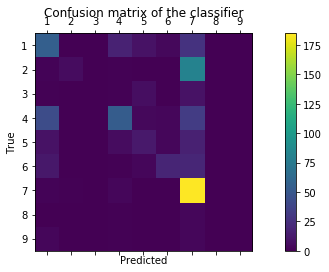

In [50]:
#Let's try the Naive Bayes classifier as the SVM isn't working.
#Naive Bayes is known to work suprisingly well for text data
from sklearn.naive_bayes import MultinomialNB

import pylab as pl
nb = MultinomialNB()
nb.fit(train_feats_chi2, train_labels)
preds = nb.predict(valid_feats_chi2)

acc = accuracy(preds, np.array(valid_labels))
print("Validation Accuracy: " + str(acc))

scores = cross_val_score(nb,train_feats_chi2, train_labels,  cv=5)
print("Cross Validation Scores: ", scores)
#Print confusion matrix
#labels = ["Class" + str(i) for i in range(1,10)]
nb_conf_mat = confusion_matrix(valid_labels, preds, labels = range(1,10))
print(nb_conf_mat)


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(nb_conf_mat)
pl.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + range(1,10))
ax.set_yticklabels([''] + range(1,10))
pl.xlabel('Predicted')
pl.ylabel('True')
pl.show()



In [51]:
from sklearn import linear_model
from sklearn.metrics import recall_score, precision_score, f1_score
log = linear_model.LogisticRegression()
##One Hot encode training labels
#train_labels = np.array(pd.get_dummies(train_df["Class"]))
#valid_labels = np.array(pd.get_dummies(valid_df["Class"]))
#train_labels = train_df["Class"].tolist()
#valid_labels = valid_df["Class"].tolist()
log.fit(train_feats, train_labels)
scores = cross_val_score(log,train_feats, train_labels,  cv=5)
preds = log.predict(valid_feats)
acc = accuracy(preds, valid_labels)
print("Validation Accuracy: " + str(acc))

#Print recall_score
print("Recall Score: ", recall_score(valid_labels, preds, average = "weighted"))

#Print precision score
print("Precision Score: ", precision_score(valid_labels, preds,average = "weighted"))

#Print confusion matrix
log_conf_mat = confusion_matrix(valid_labels, preds, labels = range(1,10))
print(log_conf_mat)

Validation Accuracy: 59
('Recall Score: ', 0.59699248120300752)
('Precision Score: ', 0.62023083719576155)
[[ 63   2   0  28   9   2  10   0   0]
 [  4  28   0   1   3   0  55   0   0]
 [  1   1   2   3   4   0   7   0   0]
 [ 30   1   0  83   2   2  19   0   0]
 [  8   1   0   9  11   2  17   0   0]
 [  8   0   0   9   1  24  13   0   0]
 [  2   3   0   3   0   0 183   0   0]
 [  0   0   0   1   0   0   3   0   0]
 [  0   1   0   3   0   0   0   0   3]]


/home/nitin/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [52]:
##Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(random_state=42).fit(train_feats,train_labels)

preds = dtree.predict(valid_feats)

#scores = cross_val_score(dtree, train_feats, train_df["Class"], cv=5)
#print(scores)

acc = accuracy(preds, valid_labels)
print("Validation Accuracy: " + str(acc))

#Print recall_score
print("Recall Score: ", recall_score(valid_labels, preds, average = "weighted"))

#Print precision score
print("Precision Score: ", precision_score(valid_labels, preds,average = "weighted"))

#Print confusion matrix
dtree_conf_mat = confusion_matrix(valid_labels, preds, labels = range(1,10))
print(dtree_conf_mat)

Validation Accuracy: 55
('Recall Score: ', 0.5518796992481203)
('Precision Score: ', 0.54604401508279321)
[[ 60   8   0  29  10   4   3   0   0]
 [  6  39   0   7   7   1  31   0   0]
 [  3   0   5   3   3   1   3   0   0]
 [ 27   8   3  80   2   5  10   0   2]
 [ 17   2   1   5  12   4   7   0   0]
 [  9   3   0   2   3  30   8   0   0]
 [  5  28   3   7   6   2 137   0   3]
 [  0   1   0   1   0   0   2   0   0]
 [  1   0   0   0   0   0   2   0   4]]


In [53]:
##Trying GBM before heading to XGBoost

from sklearn.ensemble import GradientBoostingClassifier


gbm = GradientBoostingClassifier(verbose = 1, max_depth=3,n_estimators=200).fit(train_feats_chi2,train_labels)
preds = gbm.predict(valid_feats_chi2)
test_preds = gbm.predict(test_feats_chi2)
#scores = cross_val_score(dtree, train_feats, train_df["Class"], cv=5)
#print(scores)

acc = accuracy(preds, valid_labels)
print("Validation Accuracy: " + str(acc))

#Print recall_score
print("Recall Score: ", recall_score(valid_labels, preds, average = "weighted"))

#Print precision score
print("Precision Score: ", precision_score(valid_labels, preds,average = "weighted"))

make_submission(predictions=test_preds,test_df=test_df)

      Iter       Train Loss   Remaining Time 
         1        4974.5918            3.63m
         2        4536.5290            3.67m
         3        4206.6064            3.65m
         4        3942.7054            3.65m
         5        3729.3517            3.66m
         6        3549.2955            3.65m
         7        3381.4771            3.60m
         8        3236.0427            3.59m
         9        3111.9499            3.54m
        10        2998.7230            3.51m
        11        2897.0265            3.49m
        12        2801.1299            3.49m
        13        2723.3643            3.44m
        14        2654.1016            3.41m
        15        2579.3946            3.39m
        16        2508.6383            3.37m
        17        2450.0542            3.35m
        18        2390.2860            3.32m
        19        2344.2317            3.29m
        20        2293.3216            3.26m
        21        2244.0903            3.24m
        2

       183         894.2296           16.10s
       184         891.6248           15.16s
       185         889.6805           14.20s
       186         887.1495           13.24s
       187         884.8553           12.29s
       188         882.7021           11.34s
       189         880.1496           10.39s
       190         878.2472            9.45s
       191         875.5859            8.50s
       192         872.5928            7.56s
       193         869.5961            6.61s
       194         867.1853            5.67s
       195         864.9247            4.72s
       196         863.1722            3.77s
       197         861.5729            2.83s
       198         859.2164            1.89s
       199         856.8074            0.94s
       200         854.0381            0.00s
Validation Accuracy: 62
('Recall Score: ', 0.62857142857142856)
('Precision Score: ', 0.62815970788053466)
['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'c

array([   1,    3,    4, ..., 7996, 8000, 8001])

In [28]:

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train_labels_onehot = pd.get_dummies(train_labels)
valid_labels_onehot = pd.get_dummies(valid_labels)

train_labels_xgb = [i-1 for i in train_labels]
valid_labels_xgb = [i-1 for i in valid_labels]

param_dict = {
    "learning_rate" :0.1,
    "n_estimators":1000,
    "max_depth":5,
    "min_child_weight":1,
    "gamma":0,
    "subsample":0.8,
    "colsample_bytree":0.8,
    "objective": 'multi:softmax',
    "nthread":4,
    "scale_pos_weight":1,
    "seed":42
}

alg = XGBClassifier()
alg.set_params(**param_dict)



fit_params = {
'early_stopping_rounds': 30,
'eval_metric': 'mae',
'eval_set': [[train_feats_chi2,train_labels]]
}

grid = GridSearchCV(alg, param_dict, cv=5,fit_params=fit_params)
grid.fit(train_feats_chi2,train_labels_xgb)

y_pred = model.predict(valid_feats_chi2)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(valid_labels_xgb, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))



#predictors = [feature_names[i] for i in ch2.get_support(indices=True)]
#print(predictors[0:10])
"""
useTrainCV = True
cv_folds = 5
early_stopping_rounds = 50

    
if useTrainCV:
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(train_feats, label=train_labels)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='mlogloss', early_stopping_rounds=early_stopping_rounds,seed = 42)
    alg.set_params(n_estimators=cvresult.shape[0])

        
#Predict training set:
dtrain_predictions = alg.predict(valid_feats)
dtrain_predprob = alg.predict_proba(valid_feats)[:,1]
        
#Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(valid_labels, dtrain_predictions))
print("AUC Score (Train): %f" % metrics.roc_auc_score(valid_labels, dtrain_predprob))
                    
feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
#Fit the algorithm on the data
alg.fit(train_feats,train_labels_xgb, eval_metric='mlogloss',verbose = True)


    
model = XGBClassifier()
model.fit(train_feats, train_labels_xgb, verbose = True)
# make predictions for test data
y_pred = model.predict(valid_feats)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(valid_labels_xgb, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
"""



ValueError: Parameter values for parameter (scale_pos_weight) need to be a sequence.

In [40]:
import xgboost
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.grid_search import GridSearchCV

# Load and process train users

xgb_model = xgboost.XGBClassifier(objective="multi:softmax", nthread=-1,subsample=0.8)

clf = GridSearchCV(
    xgb_model,
    {
        'max_depth': [5],
        'n_estimators': [500],
        'learning_rate': [0.2]
    },
    cv=5,
    verbose=6,
    n_jobs=1,
    scoring=make_scorer(accuracy_score)
)


clf.fit(train_feats_chi2, train_labels_xgb)
feat_imp = pd.Series(xgb_model.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] n_estimators=500, learning_rate=0.2, max_depth=5 ................
[CV]  n_estimators=500, learning_rate=0.2, max_depth=5, score=0.687266 - 4.5min
[CV] n_estimators=500, learning_rate=0.2, max_depth=5 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.5min remaining:    0.0s


[CV]  n_estimators=500, learning_rate=0.2, max_depth=5, score=0.680451 - 4.9min
[CV] n_estimators=500, learning_rate=0.2, max_depth=5 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.4min remaining:    0.0s


[CV]  n_estimators=500, learning_rate=0.2, max_depth=5, score=0.636535 - 4.7min
[CV] n_estimators=500, learning_rate=0.2, max_depth=5 ................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 14.1min remaining:    0.0s


[CV]  n_estimators=500, learning_rate=0.2, max_depth=5, score=0.623352 - 4.7min
[CV] n_estimators=500, learning_rate=0.2, max_depth=5 ................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 18.9min remaining:    0.0s


[CV]  n_estimators=500, learning_rate=0.2, max_depth=5, score=0.696970 - 5.5min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 24.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 24.4min finished


XGBoostError: need to call fit beforehand

In [54]:
train_df["Text"][0]

u'abstract germline mutations that inactivate the tumor suppressor gene brca are associated with an increased risk of cancers of the breast and other tissues but the functional consequence of many missense variants found in the human population is uncertain several predictive methods have been proposed to distinguish cancer predisposing missense mutations from harmless polymorphisms including a small colony phenotype scp assay performed in the model organism yeast saccharomyces cerevisiae the goal of this study was to further evaluate this colony size assay we constructed missense mutations throughout the c terminal amino acid residues of brca mutated proteins were expressed in yeast and evaluated using the scp assay we conclude there is as yet no evidence the assay can identify inactivating mutations upstream of the brct repeats however within and between the brct repeats results of the assay are in general agreement with predictions based on structural modeling other in vitro and in 